<div style="text-align: center;">
<h1 style="font-weight: bold; margin: 20px 0;">
Adaptation Futures Conference (AF2025) Training - Illustrating Climate Risk Exposure with CCI Data 
</h1>
</div>


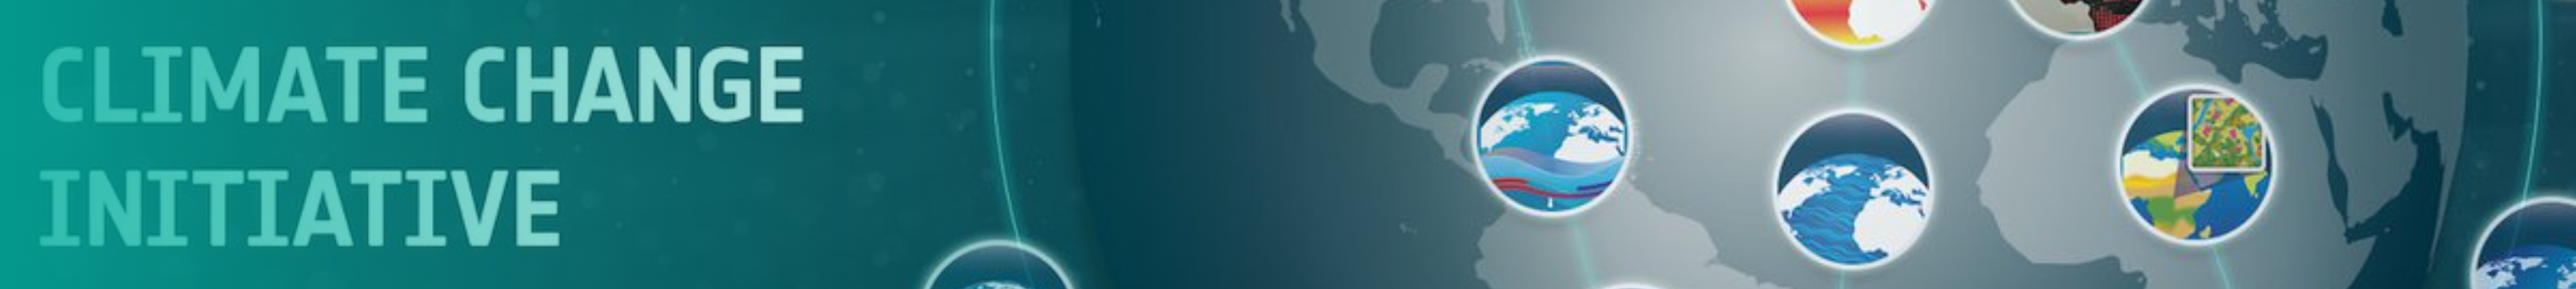

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">
<h2 style="margin: 0 0 15px 0; font-size: 1.4em;">1. Introduction:</h2>

In this beginner-friendly notebook, we will use real satellite-based Essential Climate Variables (ECVs) data from the [ESA Climate Change Initiative (CCI)](https://climate.esa.int/en/odp/#/dashboard) to explore recent climate trends. We will also look at how to combine population dataset with ECVs to have a first-order estimation of risk exposure caused by extreme weather events.

This notebook is designed for **participants with no prior experience in Python or climate data analysis**. You will learn:

- How to access CCI ECVs using the CCI Toolbox python Package
- How to navigate and subset climate data using Xarray
- How to compute basic plots using Matplotlib
- How to save a figure you generated
- How to map and interpret ECVs changes over time and space
</div>

## Step 1. Setup & Imports

Before we start working with the data, we need to import a few Python libraries. These libraries provide useful tools for working with satellite data, performing simple calculations, and creating visualizations.

Don’t worry if you’re not familiar with these yet — we will explain what you need as we go.

In [1]:
# ESA Climate Toolbox imports for accessing and plotting ESA CCI data
from esa_climate_toolbox.core import get_op              # Get predefined operations (e.g., time series, averages)
from esa_climate_toolbox.core import list_ecv_datasets   # List available datasets per ECV (Essential Climate Variable)
from esa_climate_toolbox.core import get_store           # Connect to an ESA data store
from esa_climate_toolbox.core import list_datasets       # List all datasets in a store
from esa_climate_toolbox.core import search
from esa_climate_toolbox.ops import plot                 # High-level plotting functions for CCI data

# Used for connecting to remote data sources (e.g., ESA CCI ODP)
from xcube.core.store import new_data_store

# For displaying geographic regions interactively (if desired)
from IPython.display import GeoJSON
import shapely.geometry   # Handling geometric objects like bounding boxes

# Core data science libraries
import pandas as pd       # For tabular data handling and time manipulation
import numpy as np        # For numerical operations
import xarray as xr       # For multi-dimensional climate data structures

# Mapping and plotting
import matplotlib.pyplot as plt       # Plotting library
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs            # Cartographic projections for spatial data
import cartopy.feature as cfeature
import rasterio                       # Used to read GeoTIFF files

# Notebook settings
import warnings
warnings.filterwarnings("ignore") # Suppressing warnings to keep notebook output clean
%matplotlib inline

#### **Why we need those Python packages:**

* `numpy`: helps with numbers and arrays.
* `matplotlib`: lets us create plots and maps.
* `xarray`: makes it easy to work with climate datasets.
* `cartopy`: helps plot maps with geographic context.
* `Toolbox`: a package that facilitates access and computation of CCI data

##### ***Up next:*** We will learn how to **access ECVs** from the CCI Toolbox.

In [2]:
#list_datasets("esa-cci-zarr")

## Step 2: Load & Visualize Land Surface Temperature data (LST)
### Define the Dataset ID
To work with a specific ESA CCI dataset, we need to specify its **dataset ID**. This unique identifier tells the toolbox which variable and product we want to access. 
When using the command `list_ecv_datasets`, you can see all available datasets for the chosen parameter (in this case `"LST"`). 

First, we define the dataset ID and the store from which we retrieve the data (for the LST file it is `esa-cci`). 
In this section, we are using **land surface temperature (LST)** data from the esa-cci-zarr store. You can find the variables of the products under **data_vars**. For the LST, we will use the variable **lst**. 



In [3]:
# Uncomment (-> remove the "# ") the next line, if you wish to see all available datafiles for the LST
#list_ecv_datasets("LST")

In [2]:
# Open the ESA CCI store
cci_store = new_data_store("esa-cci-zarr")
# define the dataset ID
data_id = 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1MONTHLY_DAY-1995-2020-fv3.00.zarr'

### Describe Dataset (Check Available Variables and Metadata)

Before loading the full dataset, it’s helpful to **inspect the metadata** to understand its structure by using the command `describe_data`. This includes:

- Available variables (e.g., lst, uncertainty estimates)
- Temporal and spatial coverage
- Data format and structure

This step ensures we know what the dataset contains and how to work with it. It also helps confirm that the variable we want to plot or analyze is actually included.

🛠️ Tip: You can use the description to verify variable names, dimensions (e.g., `lat`, `lon`, `time`), and time coverage. Under **data_vars** you can find the data variables and the **attrs** within the **data_vars** section show you the data attributes, e.g. the long name of the variable or the unit.

📘 More on dataset structure:  
🔗 [ESA Climate Toolbox – Data Access](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#accessing-data)

In [3]:
# Inspect the data structure
cci_store.describe_data(data_id)

### Load the Dataset 

Now that we have an understanding of the data structure and have defined the data store and ID, we can open the dataset by using the command `open_data`. 

We can then inspect the data structure and content by displaying the dataset. The displayed dataset is interactive in Jupyter Notebooks, thus you can use the arrows to see the content of the dataset, e.g. the Data variables or Coordinates and you can click on the container symbol ☰ to see what is inside. 


In [6]:
lst_ds = cci_store.open_data(
    data_id=data_id,
)
display(lst_ds)

<xarray.Dataset> Size: 18TB
Dimensions:          (time: 294, lat: 18000, lon: 36000, length_scale: 294,
                      channel: 2)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 72kB -90.0 -89.99 -89.98 ... 89.98 89.99
  * lon              (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time             (time) datetime64[ns] 2kB 1995-08-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lcc              (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst              (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    n                (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    sataz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    satze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solaz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3S global land surf...
    time_coverage_duration:     P1M
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...

### Create a spatial subset of the LST data:

To focus our analysis on New Zealand, we now extract a **spatial subset** from the global LST dataset.

Using the **bounding box (bbox)** we define here, the function `subset_spatial` filters the dataset to include only the relevant area.

This helps **reduce data volume** and enables more **targeted visualizations and calculations** in the following steps.

Below are several longitudes and latitudes to choose from. In the comment above, you can read which area they cover.

In [7]:
# Set bounding box to New Zealand 
#lat_min = -53.0
#lat_max = -33.0
#lon_min = 165.0
#lon_max = 180.0  # Chatham Islands cannot be included here, as it is behind the 180th meridian of the longitude

In [5]:
# # Set bounding box to Christchurch
lat_min = -44
lat_max = -43.2
lon_min = 172.3
lon_max = 173.8

In [7]:
# Set bounding box to South Island
lat_min = -47.78
lat_max = -39.23
lon_min = 166.1
lon_max = 174.9

In [6]:
# Set bounding box to North Island
lat_min = -42.0
lat_max = -34.0
lon_min = 172.0
lon_max = 180.0

In [8]:
bbox = (lon_min, lat_min, lon_max, lat_max)  # Fixed order: (lon_min, lat_min, lon_max, lat_max)
# Display bounding box for reference
GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

### Choosing an operator

The toolbox offers a variety of operators to choose which we can apply on the dataset. For creating a spatial subset, we would use the `subset_spatial` operator, for the temporal subset, we would use the `subset_temporal` operator. In the following cells, you can see how we call the operators and how we apply them to the data.

The [available operators](https://esa-climate-toolbox.readthedocs.io/en/latest/notebooks/Using_Operations/1-ECT_Finding_Operations.html#Finding-Operations) can be listed via `list_operations` as shown below.

In [9]:
#Toolbox operators
from esa_climate_toolbox.core import list_operations
list_operations()

['add_dataset_values_to_geodataframe',
 'adjust_spatial_attrs',
 'adjust_temporal_attrs',
 'aggregate_statistics',
 'animate_map',
 'anomaly_external',
 'anomaly_internal',
 'arithmetics',
 'as_geodataframe',
 'climatology',
 'coregister',
 'data_frame_max',
 'data_frame_min',
 'data_frame_subset',
 'detect_outliers',
 'diff',
 'find_closest',
 'fourier_analysis',
 'gapfill',
 'merge',
 'normalize',
 'plot',
 'plot_contour',
 'plot_hist',
 'plot_line',
 'plot_map',
 'plot_scatter',
 'query',
 'reduce',
 'resample',
 'select_features',
 'select_var',
 'statistics',
 'subset_spatial',
 'subset_temporal',
 'subset_temporal_index',
 'temporal_aggregation',
 'to_dataframe',
 'to_dataset',
 'tseries_mean',
 'tseries_point']

If you would like to read more about the different operations, e.g. what they are doing, what is needed as input and output, you can retrieve this information as shown below.

In [10]:
from IPython.display import JSON
from esa_climate_toolbox.core import get_op_meta_info

JSON(get_op_meta_info('subset_spatial'))

<IPython.core.display.JSON object>

In [11]:
# Create the spatial subset with the bbox defined above
subset_spatial_op = get_op('subset_spatial')
lst_ds_sub = subset_spatial_op(ds=lst_ds, region=bbox)
lst_ds_sub

<xarray.Dataset> Size: 21GB
Dimensions:          (time: 294, lat: 857, lon: 882, length_scale: 294,
                      channel: 2)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.22
  * lon              (lon) float32 4kB 166.1 166.1 166.1 ... 174.9 174.9 174.9
  * time             (time) datetime64[ns] 2kB 1995-08-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lcc              (time, lat, lon) float32 889MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst              (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    n                (time, lat, lon) float32 889MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    sataz            (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    satze            (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solaz            (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solze            (time, lat, lon) float64 2GB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((166.08999633789062 -47.7900009155273...

#### Climatology operator

To create a "mean over years" dataset, the [climatology operator](https://esa-climate-toolbox.readthedocs.io/en/latest/api_reference.html#esa_climate_toolbox.ops.climatology) averages the values of the given input data over all years. This is applied in the same time resolution as the given dataset, meaning - a daily dataset will calculate a daily average over all years, a monthly dataset will calculate a monthly average accross all years. 

Note: the resulting monthly or daily data will be attributed to the first time array. In the case below, the dataset has a time array rom 1995 containing all averages from 1995-2020.

In [13]:
climatology_op = get_op('climatology')
lst_ds_clim = climatology_op(ds=lst_ds_sub)
lst_ds_clim # use this to have a quick look into the metadata

<xarray.Dataset> Size: 871MB
Dimensions:             (time: 12, lat: 857, lon: 882, length_scale: 294,
                         channel: 2, nv: 2)
Coordinates:
  * channel             (channel) float64 16B 11.0 12.0
  * lat                 (lat) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.22
  * lon                 (lon) float32 4kB 166.1 166.1 166.1 ... 174.9 174.9
  * time                (time) datetime64[ns] 96B 1995-01-01 ... 1995-12-01
Dimensions without coordinates: length_scale, nv
Data variables: (12/15)
    dtime               (time, lat, lon) timedelta64[ns] 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lcc                 (time, lat, lon) float32 36MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst                 (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_atm     (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_cor     (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_sfc     (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    ...                  ...
    n                   (time, lat, lon) float32 36MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    sataz               (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    satze               (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solaz               (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solze               (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    climatology_bounds  (time, nv) datetime64[us] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((166.08999633789062 -47.7900009155273...

### Plot a spatial map using the toolbox
Let's plot the climatology dataset using the toolbox. As index, we choose `'time' : '1995-01-01'`, meaning, we look at the mean LST in January from 1995-2020. 

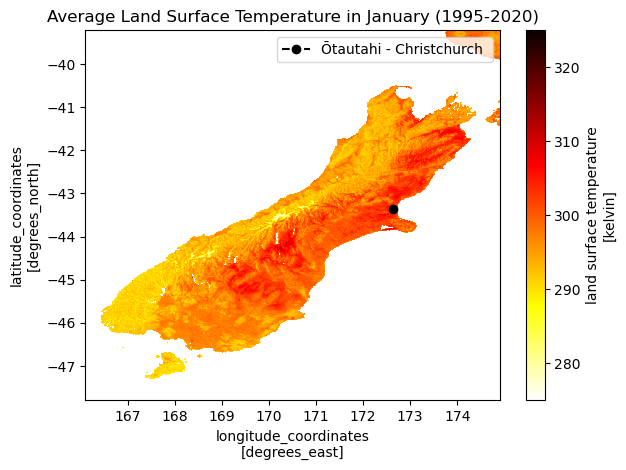

In [24]:
plot_op = get_op('plot')
# Create a plot of the LST data

plot_op(
    ds=lst_ds_clim,  # Dataset variable
    var='lst',       # Variable you want to plot  # Specify the date
    title="Average Land Surface Temperature in January (1995-2020)",
     indexers={'time': '1995-01-01'},  # Specify the date
    properties="cmap='hot_r', vmin=275, vmax= 325", # Pass other properties here, such as color
)

#
#Latitude, 43° 31' 55.39"S. Longitude, 172° 38' 10.41"E
city_lat, city_lon = -43.353, 172.636
plt.plot(city_lon, city_lat, linestyle='--', marker='o', color='k', label='Ōtautahi - Christchurch ')
plt.legend()


#### Temporal subset
Next, we do a temporal subset of the dataset and choose only 2019.

In [14]:
subset_temporal_op = get_op('subset_temporal')
lst_ds_sub = subset_temporal_op(ds=lst_ds_sub, time_range=['2019-01-01', '2019-12-01'])
lst_ds_sub 

<xarray.Dataset> Size: 871MB
Dimensions:          (time: 12, lat: 857, lon: 882, length_scale: 294,
                      channel: 2)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.22
  * lon              (lon) float32 4kB 166.1 166.1 166.1 ... 174.9 174.9 174.9
  * time             (time) datetime64[ns] 96B 2019-01-01 ... 2019-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lcc              (time, lat, lon) float32 36MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst              (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    n                (time, lat, lon) float32 36MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    sataz            (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    satze            (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solaz            (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
    solze            (time, lat, lon) float64 73MB dask.array<chunksize=(1, 279, 882), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          2019-12-01T00:00:00
    time_coverage_resolution:   P1M
    time_coverage_start:        2019-01-01T00:00:00
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((166.08999633789062 -47.7900009155273...

Now let's look at a heatwave year: 2019, in particular we will focus on January to see how we can combine LST and population data

In [15]:
#January 2019 LST data selection
lst_19_j=lst_ds_sub.lst.sel(time='2019-01-01')-273.15

In [16]:
extent=[lon_min,lon_max,lat_min,lat_max]

### Combine the land surface temperature data with a population density map
We can combine satellite data with socio-economic data, such as density population maps.
The data is retrieved from the [**Global Human Settlement Layer**](https://human-settlement.emergency.copernicus.eu/download.php) from 2020 (note, that 2019 is not available). The resolution is 30 arcsec and the coordination system is WGS84. The data can be downloaded as **tif** file for several grids and the grids covering New Zealand have already been merged and can be found inside the same folder, where the Jupyter Notebook is stored. 
The **tif** format includes relevant metadata, such as latitude and longitude, which allows us to combine it with the satellite data.

The data is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).  

The data has been processed (merged and clipped) for visualisation purposes in this notebook.

In [17]:
# Load population density raster
with rasterio.open("merged_population_NewZealand2020_density.tif") as src:
    pop_density = src.read(1) 
    bounds = src.bounds  # get the geographical boundaries of the tif file (left, bottom, right, top)
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top] # define the extent of the tif file

In [22]:
lst_da_crs = lst_19_j.rio.write_crs("EPSG:4326", inplace=True) #coordinates are in degrees: use EPSG:4326.
lst_da_crs

<xarray.DataArray 'lst' (lat: 857, lon: 882)> Size: 6MB
dask.array<sub, shape=(857, 882), dtype=float64, chunksize=(578, 882), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.24 -39.22
  * lon          (lon) float32 4kB 166.1 166.1 166.1 166.1 ... 174.9 174.9 174.9
    time         datetime64[ns] 8B 2019-01-01
    spatial_ref  int64 8B 0

In [23]:
#Matching Population density data grid to the LST grid
import rioxarray

# Load population density  as xarray DataArray
pop_da = rioxarray.open_rasterio("merged_population_NewZealand2015_density.tif", masked=True).squeeze()

# Regrid to LST dataset grid
pop_da_matched = pop_da.rio.reproject_match(lst_da_crs)

extent = [float(pop_da_matched.x.min()), float(pop_da_matched.x.max()),
          float(pop_da_matched.y.min()), float(pop_da_matched.y.max())]

In [24]:
pop_da_matched

<xarray.DataArray (y: 857, x: 882)> Size: 6MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(857, 882))
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float32 4kB 166.1 166.1 166.1 166.1 ... 174.9 174.9 174.9
  * y            (y) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.24 -39.22
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [51]:
#Creating an xarray for population density
pop_dens= xr.DataArray(pop_da_matched, coords=lst_19_j.coords, dims=lst_19_j.dims)

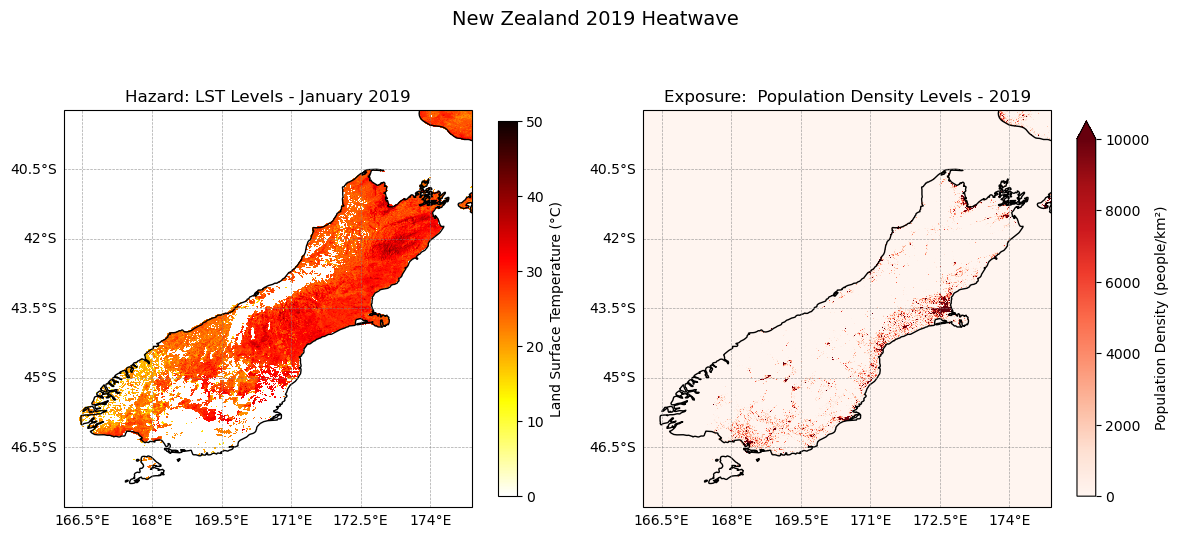

In [60]:
# Create side-by-side subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plotting LST
plot_lst= lst_19_j.plot(ax=axes[0], cmap='hot_r', vmin=0, vmax=50, transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': 'Land Surface Temperature (°C)', 'orientation': 'vertical', 'shrink': 0.7})

# Add coastlines and borders
axes[0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0].add_feature(cfeature.BORDERS, linestyle=':')
# Set map extent (adjust as needed)
axes[0].set_extent(extent)
#cbar0.set_label('LST Risk Level', fontsize=10)
gl0 = axes[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl0.top_labels = False
gl0.right_labels = False

axes[0].set_title('Hazard: LST Levels - January 2019', fontsize=12)
axes[0].set_xlabel('Longitude [°E]')
axes[0].set_ylabel('Latitude [°N]')

#Plotting population density
plot_pop= pop_dens.plot(ax=axes[1],cmap='Reds', vmin=0, vmax=10000,  transform=ccrs.PlateCarree(),  
                        cbar_kwargs={'label': 'Population Density (people/km²)', 'orientation': 'vertical', 'shrink': 0.7})
axes[1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].set_extent(extent)
# Add colorbar
gl1 = axes[1].gridlines( draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

axes[1].set_title('Exposure:  Population Density Levels - 2019', fontsize=12)
axes[1].set_xlabel('Longitude [°E]')
axes[1].set_ylabel('Latitude [°N]')

plt.suptitle('New Zealand 2019 Heatwave', fontsize=14, y=0.97)
plt.tight_layout()
plt.show()

In [39]:
#Reclassifying LST and population density for risk maps

In [27]:
# Define classes for grouping LST data
#low : , medium: , high: 
#LST levels 

#very low < 20 value 1 
#low < 20-30°C value 2 
#Medium 30-35 °C value 3 
#High <35° - 40°C value 4  
#Very High 40–50	5
#Extreme >50°  value 6
lst_bins   = [20, 30, 35, 40, 50]
lst_values = [1, 2, 3, 4, 5]

In [28]:
# Function to reclassify data to match each value ranges to a level of risk
def reclassify_with_numpy_ge(array, bins, new_values):
    reclassified_array = np.zeros_like(array)
    reclassified_array[array < bins[0]] = new_values[0]  # below first bin
    for i in range(len(bins) - 1):
        reclassified_array[(array >= bins[i]) & (array < bins[i + 1])] = new_values[i]
    reclassified_array[array >= bins[-1]] = new_values[-1]  # above last bin
    return reclassified_array

In [29]:
# Apply the reclassification function
lst_class = reclassify_with_numpy_ge(lst_19_j.values, bins=lst_bins, new_values=lst_values)

In [30]:
# Convert the reclassified array back to xarray DataArray for plotting
lst_class_da = xr.DataArray(lst_class, coords=lst_19_j.coords, dims=lst_19_j.dims)

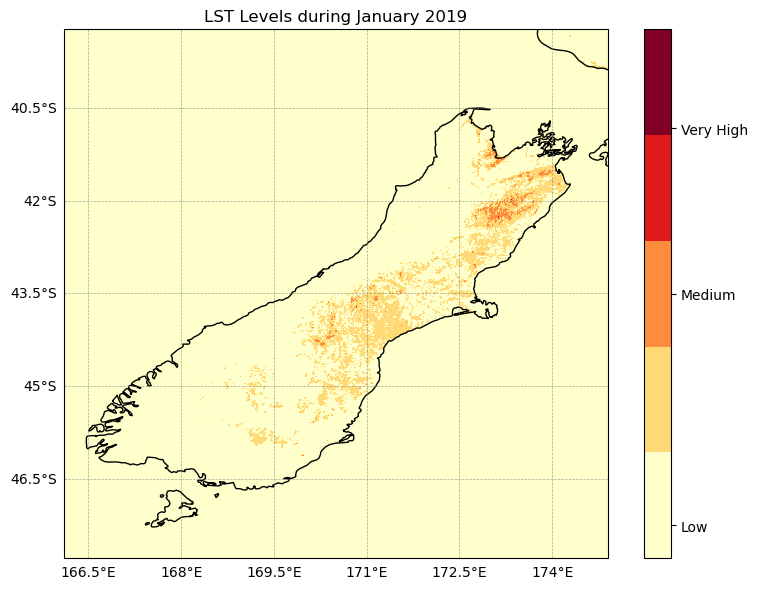

In [31]:
cmap = plt.get_cmap('YlOrRd', 5) 


fig, ax = plt.subplots(figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the data
plot_lst= lst_class_da.plot(ax=ax, cmap=cmap, vmin=1, vmax=5, transform=ccrs.PlateCarree() , add_colorbar=False)

# Add New Zealand coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_ylim(lat_min,lat_max)
ax.set_xlim(lon_min,lon_max)

# Colorbar
cbar = fig.colorbar(plot_lst, ticks=[1.25, 3., 4.25])
cbar.ax.set_yticklabels(['Low', 'Medium', 'Very High'], size=10)

#very low < 20 value 1 
#low < 20-30°C value 2 
#Medium 30-40 °C value 3 
#High <40° - 50°C value 4  
#Very High 50–55	5
#Extreme >55°  value 6

# Add gridlines with labels
grid = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
grid.top_labels = False
grid.right_labels = False

ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('LST Levels during January 2019', size=12)
plt.show()

In [32]:
#Reclassifying Population Density for risk maps

In [33]:
#defining level ranges for population density 
pop_bins = [0, 50, 100, 1000, 10000]  # Effect on the human health
pop_values = [1, 2, 3, 4, 5]

In [34]:
# Apply the reclassification function
pop_class = reclassify_with_numpy_ge(pop_da_matched, bins=pop_bins, new_values=pop_values)

In [35]:
#Creating an xarray for population density classified
pop_class_da = xr.DataArray(pop_class, coords=lst_19_j.coords, dims=lst_19_j.dims)

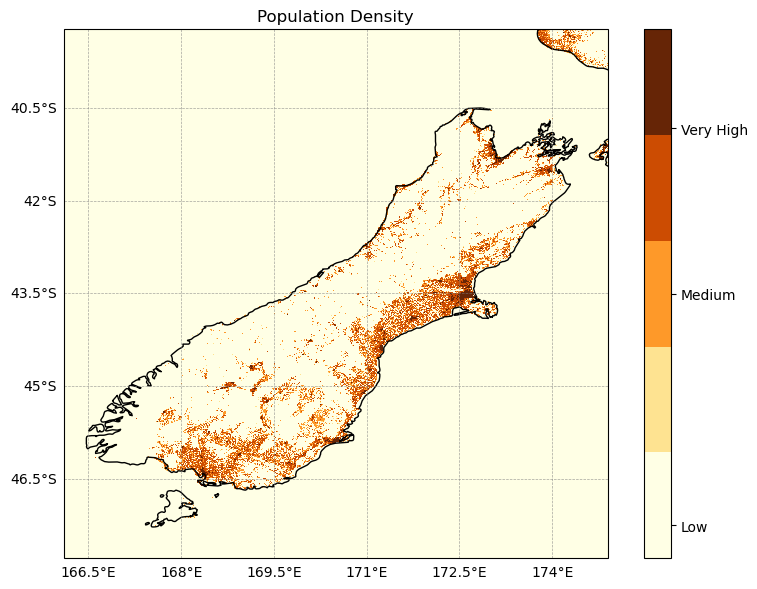

In [36]:
cmap = plt.get_cmap('YlOrBr', 5) 
fig, ax = plt.subplots(figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree()})
plot_pop= pop_class_da.plot(ax=ax, cmap=cmap, vmin=1, vmax=5, transform=ccrs.PlateCarree(),  add_colorbar=False,)

cbar = fig.colorbar(plot_pop, ticks=[1.25, 3., 4.25])
cbar.ax.set_yticklabels(['Low', 'Medium', 'Very High'], size=10)

# Add New Zealand coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_ylim(lat_min,lat_max)
ax.set_xlim(lon_min,lon_max)

# Add gridlines with labels
grid = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
grid.top_labels = False
grid.right_labels = False

plt.title("Population Density")
plt.tight_layout()
plt.show()

In [37]:
#Risk exposure to heat
risk_map = lst_class_da + pop_class
risk_map

<xarray.DataArray (lat: 857, lon: 882)> Size: 6MB
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.]], shape=(857, 882))
Coordinates:
  * lat          (lat) float32 3kB -47.78 -47.78 -47.76 ... -39.24 -39.24 -39.22
  * lon          (lon) float32 4kB 166.1 166.1 166.1 166.1 ... 174.9 174.9 174.9
    time         datetime64[ns] 8B 2019-01-01
    spatial_ref  int64 8B 0

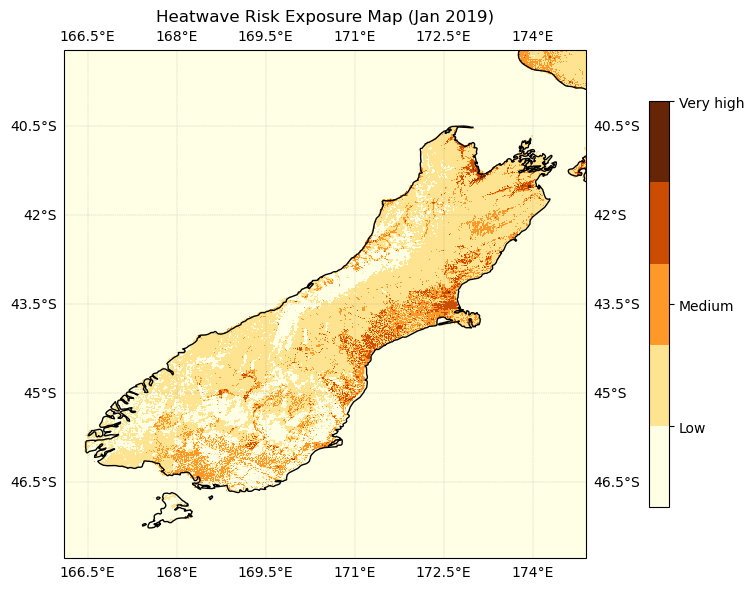

In [49]:
#Now let's plot the risk exposure map showing where high heat coincides with high pop exposure
#Risk=LST Level+Population Density Level
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
risk_plot= risk_map.plot(ax=ax, vmin=0, vmax=10, cmap=cmap,  add_colorbar=False, transform=ccrs.PlateCarree())

cbar = fig.colorbar(risk_plot, ticks=[2, 5,  10], pad=0.09, shrink=0.8, fraction=0.03) #pad: reduce space between plot/colorbar
cbar.ax.set_yticklabels([ 'Low', 'Medium', 'Very high'], size=10)
ax.set_title('Heatwave Risk Exposure Map (Jan 2019)')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent(extent)
#PLot around Christchurch only:
#ax.set_extent([172.3, 173.8, -44, -43.2], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()

plt.savefig('risk_map.png')
plt.show()

Zoom into Christchurch: 

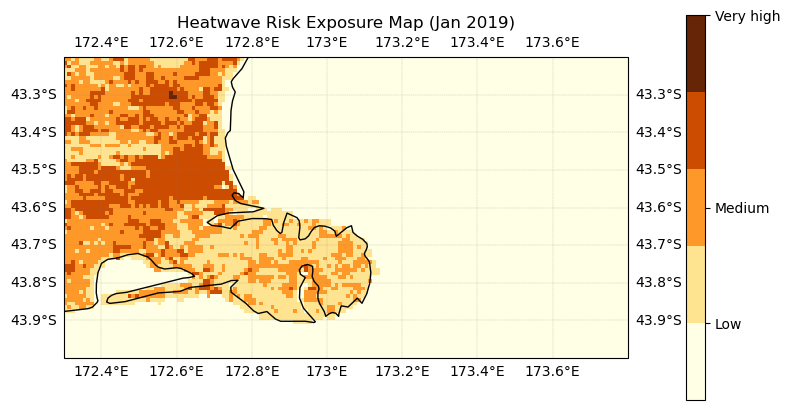

In [52]:
#Now let's plot the risk exposure map showing where high heat coincides with high pop exposure
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
risk_plot= risk_map.plot(ax=ax, vmin=0, vmax=10, cmap=cmap,  add_colorbar=False, transform=ccrs.PlateCarree())

cbar = fig.colorbar(risk_plot, ticks=[2, 5,  10], pad=0.09, shrink=0.8, fraction=0.03) #pad: reduce space between plot/colorbar
cbar.ax.set_yticklabels([ 'Low', 'Medium', 'Very high'], size=10)
ax.set_title('Heatwave Risk Exposure Map (Jan 2019)')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.set_extent(extent)
#PLot around Christchurch only:
ax.set_extent([172.3, 173.8, -44, -43.2], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()

plt.savefig('risk_map_Christchurch.png')
plt.show()

### <span style="color:blue">→ How to save the dataset</span>

We created a datarray file regridded on the LST grid from the population TIF dataset.
You can also save this dataset in your folder either as NetCDF or Zarr file like this: 

```
# For NetCDF
pop_dens.to_netcdf("population_density_2020.nc")

# For Zarr
pop_dens.to_zarr("population_density_2020.zarr")
```

→ see next cell, where you can uncomment the command.

<span style="color:blue">**PLEASE NOTE**: The data is very large, please ensure you have enough space to save it.</span>

In [ ]:
# For NetCDF
#pop_dens.to_netcdf("population_density_2020.nc")

# For Zarr
#pop_dens.to_zarr("population_density_2020.zarr")

Let's plot the time series of LST over Christchurch

In [54]:
#LST over CHristchurch
lat_min = -44
lat_max = -43.2
lon_min = 172.3
lon_max = 173.8
bbox = (lon_min, lat_min, lon_max, lat_max) 
subset_spatial_op = get_op('subset_spatial')
lst_ds_C = subset_spatial_op(ds=lst_ds, region=bbox)
lst_ds_C

<xarray.Dataset> Size: 349MB
Dimensions:          (time: 294, lat: 82, lon: 151, length_scale: 294,
                      channel: 2)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 328B -44.01 -43.99 -43.99 ... -43.21 -43.19
  * lon              (lon) float32 604B 172.3 172.3 172.3 ... 173.8 173.8 173.8
  * time             (time) datetime64[ns] 2kB 1995-08-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    lcc              (time, lat, lon) float32 15MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    lst              (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    n                (time, lat, lon) float32 15MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    sataz            (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    satze            (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    solaz            (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
    solze            (time, lat, lon) float64 29MB dask.array<chunksize=(1, 82, 151), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((172.29998779296875 -44.0100021362304...

In [55]:
#average LST around Christchurch area
lst_ds_C_mean=lst_ds_C.lst.mean(dim=('lat','lon'))

In [59]:
lst_ds_C_mean

<xarray.DataArray 'lst' (time: 294)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(294,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1995-08-01 1995-09-01 ... 2020-12-01

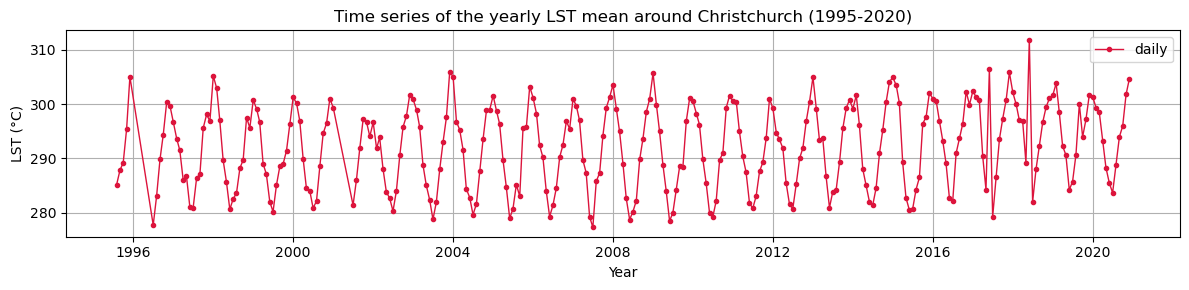

In [57]:
fig = plt.figure(figsize=(12,3))
# Define the axes
ax = fig.add_subplot(1,1,1) 

# plot the yearly mean
lst_ds_C_mean.plot(c='crimson',linewidth=1,label='daily',marker='.')

# add the labels for the axes and the title and the legend
plt.legend()
plt.grid()
plt.ylabel('LST (°C)')
plt.xlabel('Year')
plt.title("Time series of the yearly LST mean around Christchurch (1995-2020)")
plt.show()

In [58]:
lst_ds_C_mean

<xarray.DataArray 'lst' (time: 294)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(294,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1995-08-01 1995-09-01 ... 2020-12-01

### <span style="color:blue">→ How to save the time series as csv</span>

You can save the time series as **csv** file like this: 

``lst_ds_C_mean.to_dataframe(name="lst").to_csv("lst_timeseries.csv")``

→ see next cell, where you can uncomment the command

In [61]:
lst_ds_C_mean.to_dataframe(name="lst").to_csv("lst_timeseries.csv")